In [192]:
"""Lennard-Jones for specific atom"""

import numpy as np
from make_animation import make_3d_animation

class atom_props():
    """Sets atom properties"""
    def __init__(self, sigma, epsilon):
        self.sig = sigma
        self.eps = epsilon

def pot_LJ(atom,r):
    sig = atom.sig
    eps = atom.eps
    return 4*eps*((sig/r)**12 - (sig/r)**6)   

def pot_LJ_dl(r):
    r = r**-6
    u = 4*(r**2 - r)        
    return u

def grad_pot_LJ_dl(r):
    """Gradient of the Lennard Jones potential, dimensionless"""
    return -48*r**-13 + 24*r**-7 
    
def particle_generator(L, N, dim):
    """Generates random particles in the box, Velocity zero
    
    Parameters:
    -----------
    L: float
        size of the simulation box
    N: int
        Number of particles
    dim: int
        Number of dimensions      
    """
    x_init = np.random.random((dim,N))*L
    v_init = np.zeros((dim,N),dtype=float)
    return x_init, v_init

def particle_generator_fcc(L, N, dim):
    """Generates particles on a fcc lattice in 3D, 
    velocity distributed according to gaussian
    
    Parameters:
    -----------
    L: float
        size of the simulation box
    N: int
        Number of particles, should be four 
    dim: int
        Number of dimensions, should be 3      
    """
    if N == 4 and dim == 3:
        fcc_coordinates = np.array([[0,0,L/2,L/2],[0,L/2,0,L/2],[0,L/2,L/2,0]])
        x_init = fcc_coordinates
        v_init = np.zeros((dim,N),dtype=float)
    else:
        print('The dimension is not equal to 3 or the number of particles doesnt equal four.')
        import sys
        sys.exit()
    return x_init, v_init


def particle_dist(L, N, x, dim):
    """"Calculate distances between NN particle pairs
    
    Parameters:
    -----------
    L: float
        size of the simulation box
    N: int
        Number of particles
    x: array of size (N, dim)
        Particle places   
    dim: int
        Number of dimensions  
    """
    # Calcolate distances to NN
    r = np.zeros((N,N),dtype=float)
    delta_tot = np.zeros((dim,N,N),dtype=float)
    NN_max_dist = L/2       
    
    for i in range(dim):
        # Difference between coordinates per dimension
        delta = x[i,:]-np.transpose([x[i,:]])
        
        # New difference including 'virtu=al' coordinates
        delta[delta >= NN_max_dist] = -(L-delta[delta >= NN_max_dist])
        delta[delta < -NN_max_dist] = (L + delta[delta < -NN_max_dist])
        delta_tot[i] = delta
        r += delta**2   
    r = np.sqrt(r) 
    r[r == 0] = np.inf
    return delta_tot, r

def pot_and_force(delta_tot, r, dim, N):
    """Calculate forces between particles based on potential
    
    Parameters:
    -----------
    delta_tot: array of size (dim, N, N)
        Differenes between particles
    r: array of size (N, N)
        inter particle distances
    dim: int
        Number of dimensions  
    N: int
        Number of particles
    """
    # Potentials and Forces
    F = np.zeros((dim,N,N),dtype=float)
    U = 0 #0.5*sum(pot_LJ_dl(r).sum(axis=1))
    for i in range(dim):
        F[i] = -grad_pot_LJ_dl(r)*delta_tot[i]/r
    
    F_sum = F.sum(axis=1)
    return F_sum, U

# Plotting the potential for Argon
import matplotlib.pyplot as plt
k_b = 1.38e-23
argon = atom_props(3.405e-10, k_b*119.8)        

x_t = np.linspace(0.9,5,1000)
u_t = pot_LJ_dl(x_t);

plt.plot(x_t,u_t)
plt.xlabel(r'Distance r/$\sigma$')
plt.ylabel(r'Energy u/$\epsilon$')   

In [196]:
import copy as cp
import matplotlib.pyplot as plt
# Initial positions
L = 3 # Box size
N = 4 # partciles
dim = 3 # Dimensions of the probem

x_init, v_init = particle_generator_fcc(L, N, dim) 

In [199]:
delta_t = 1e-3
t_max = 500*delta_t

t_range = np.arange(0, t_max, delta_t)
x = cp.deepcopy(x_init)
v = cp.deepcopy(v_init)

E_kin = np.zeros((len(t_range),1), dtype=float)
E_pot = np.zeros((len(t_range),1), dtype=float)

pos = np.zeros((len(t_range),N,dim),dtype=float)

for i, t in enumerate(t_range):
    delta_tot, r = particle_dist(L, N, x, dim)
    F_tot, U_tot = pot_and_force(delta_tot, r, dim, N)
    # step_size = np.sum((abs((v * delta_t)) > 0.0005))
    x = (x + v * delta_t)%L
    v += F_tot * delta_t
   
    # 0.5 for double counting
    #E_kin[i] = 0.5*(1/2*v**2).sum(axis=1).sum(axis=0)
    #E_pot[i] = 0.5*U_tot.sum()
    pos[i, :, :] = x.transpose()
 

In [201]:
from IPython.display import HTML

anim = make_3d_animation(L, pos, delay=10, initial_view=(30, 20), rotate_on_play=0)
HTML(anim.to_html5_video())

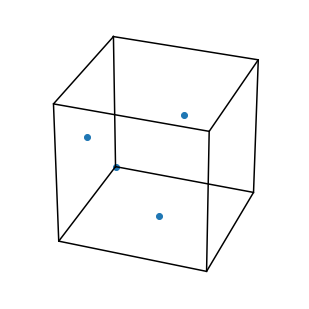

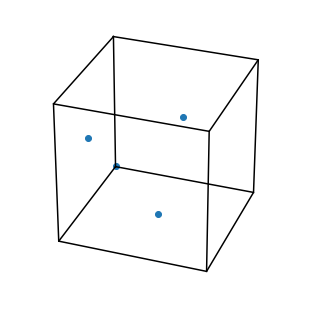

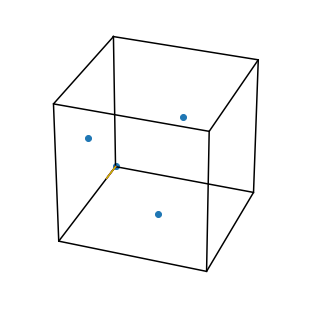

In [202]:
plt.plot(t_range,E_pot,'b')
plt.plot(t_range,E_kin,'r')
plt.plot(t_range,E_kin+E_pot,'y')
plt.show()

${\frac{d^2 \mathbf{x}}{dt^2}= \mathbf{F}(\mathbf{x}(t))}$

$\begin{aligned}
\mathbf{x}(t+h) = & \mathbf{x}(t) + h \dot{\mathbf{x}}(t) + \frac{h^2}{2} \ddot{\mathbf{x}}(t) 
+ \frac{h^3}{6} \frac{d^3}{dt^3}\mathbf{x}(t) + \mathcal{O}(h^4)\\
\mathbf{x}(t-h) = & \mathbf{x}(t) - h \dot{\mathbf{x}}(t) + \frac{h^2}{2} \ddot{\mathbf{x}}(t) 
- \frac{h^3}{6} \frac{d^3}{dt^3}\mathbf{x}(t) + \mathcal{O}(h^4)
\end{aligned}$

$\mathbf{x}(t+h) = 2 \mathbf{x}(t) - \mathbf{x}(t-h) + h^2 \mathbf{F}(\mathbf{x}(t))$

$v(t) = \frac{\mathbf{x}(t+h) - \mathbf{x}(t-h)}{2h} + \mathcal{O}(h^2)$

In [162]:
help(particle_generator)

Help on function particle_generator in module __main__:

particle_generator(L, N, dim)
    Generates random particles in the box, Velocity zero
    Parameters:
    -----------
    L: float
        size of the simulation box
    N: int
        Number of particles
    dim: int
          Number of dimensions



In [163]:
x

array([[ 0.90080002,  1.55810547,  3.37850952,  4.83136368,  0.06009674,
         3.97277069,  3.6739502 ,  4.54334927,  2.18858337,  4.0625    ,
         2.5       ,  1.98191833,  2.89962769,  1.63332748,  2.0602417 ,
         1.65930176,  0.48120117,  0.9375    ,  4.43350065,  3.08825488,
         0.62109375,  0.        ,  2.2006588 ,  3.13391495,  3.01114845,
         0.40409756,  4.37011719],
       [ 2.05281389,  1.94934082,  1.22467041,  4.92963219,  3.75115967,
         2.13129902,  2.99755859,  2.58036137,  3.75683594,  1.5546875 ,
         0.        ,  3.07287407,  2.22549152,  3.79965591,  3.68557739,
         3.01843262,  4.96721649,  1.8515625 ,  3.87453473,  4.294706  ,
         3.73278809,  2.        ,  2.54464078,  3.34400177,  1.30616379,
         2.08768797,  3.44970703],
       [ 2.35213107,  2.48657227,  0.18990517,  1.12282181,  2.35583496,
         0.61296844,  3.14602661,  2.85421264,  0.90661621,  4.875     ,
         3.        ,  1.22227478,  1.09280777,  2.7999